# Import Libraries

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transliterate import translit
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [5]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install target encoders

  Using cached target-0.0.11-py3-none-any.whl
  Using cached encoders-0.0.4-cp312-cp312-win_amd64.whl.metadata (1.1 kB)
Using cached encoders-0.0.4-cp312-cp312-win_amd64.whl (90 kB)
Note: you may need to restart the kernel to use updated packages.


# Dataset

In [8]:
df = pd.read_csv('bank_credit_scoring.csv')
df

,Задолженность,"Просрочка, дни",Первоначльный лимит,BIRTHDATE,SEX,EDU,INCOME,TERM,Рейтинг кредитной истории,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,SCORINGMARK,UNDERAGECHILDRENCOUNT,VELCOMSCORING,FAMILYSTATUS
0,6063.50,3,7000.0,1983-07-08,Мужской,Среднее специальное,703.07,60,A1,Гомельская область,КОСАКОВКА,АПК,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Женский,Высшее,1693.68,60,B2,NaN,МИНСК,Финансы и страхование,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Женский,Среднее,724.49,60,C2,ГРОДНЕНСКАЯ,ЁДКИ,Медицина и здравоохранение,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Женский,Среднее специальное,1045.84,60,A3,МИНСКАЯ,ФАНИПОЛЬ,Государственное управление,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Женский,Высшее,1092.65,60,B3,NaN,Минск,Медицина и здравоохранение,0.63,425193,NaN,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,1999-11-08,Мужской,Высшее,3563.75,60,B1,г. Минск,МИНСК,Информационные технологии,0.40,687867,344.0,0,-2.0,1
18416,0.00,0,13000.0,1993-06-03,Мужской,Среднее специальное,2865.72,36,NaN,Минская область,Жалы,Строительство,0.19,984627,108.0,2,-2.0,1
18417,0.00,0,3500.0,2002-11-05,Мужской,Среднее специальное,3363.05,24,C2,Минская область,Солигорск,Строительство,0.19,1060373,129.0,0,-2.0,2
18418,0.00,0,10000.0,2003-09-15,Мужской,Среднее,1670.13,60,C1,г. Минск,МИНСК,Торговля,0.28,1056128,179.0,0,-2.0,2


## Exploratory Data Analysis

In [9]:
df.rename({"Задолженность":"Debt",
            "Просрочка, дни":"Overdue_Days",
            "Первоначльный лимит":"Initial_Limit",
            "BIRTHDATE":"Birth_Date",
            "SEX":"Sex",
            "EDU":"Education",
            "INCOME":"Income",
            "TERM":"Loan_Term",
            "Рейтинг кредитной истории":"Credit_History_Rating",
            "LV_AREA":"Living_Area",
            "LV_SETTLEMENTNAME":"Settlement_Name",
            "INDUSTRYNAME":"Industry_Name",
            "PDN":"Probability_Default",
            "CLIENTID":"Client_ID",
            "SCORINGMARK":"Scoring_Mark",
            "UNDERAGECHILDRENCOUNT": "Underage_Children_Count",
            "VELCOMSCORING":"Velcom_Score",
            "FAMILYSTATUS":"Family_Status"}, axis=1, inplace=True)
df

,Debt,Overdue_Days,Initial_Limit,Birth_Date,Sex,Education,Income,Loan_Term,Credit_History_Rating,Living_Area,Settlement_Name,Industry_Name,Probability_Default,Client_ID,Scoring_Mark,Underage_Children_Count,Velcom_Score,Family_Status
0,6063.50,3,7000.0,1983-07-08,Мужской,Среднее специальное,703.07,60,A1,Гомельская область,КОСАКОВКА,АПК,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Женский,Высшее,1693.68,60,B2,NaN,МИНСК,Финансы и страхование,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Женский,Среднее,724.49,60,C2,ГРОДНЕНСКАЯ,ЁДКИ,Медицина и здравоохранение,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Женский,Среднее специальное,1045.84,60,A3,МИНСКАЯ,ФАНИПОЛЬ,Государственное управление,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Женский,Высшее,1092.65,60,B3,NaN,Минск,Медицина и здравоохранение,0.63,425193,NaN,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,1999-11-08,Мужской,Высшее,3563.75,60,B1,г. Минск,МИНСК,Информационные технологии,0.40,687867,344.0,0,-2.0,1
18416,0.00,0,13000.0,1993-06-03,Мужской,Среднее специальное,2865.72,36,NaN,Минская область,Жалы,Строительство,0.19,984627,108.0,2,-2.0,1
18417,0.00,0,3500.0,2002-11-05,Мужской,Среднее специальное,3363.05,24,C2,Минская область,Солигорск,Строительство,0.19,1060373,129.0,0,-2.0,2
18418,0.00,0,10000.0,2003-09-15,Мужской,Среднее,1670.13,60,C1,г. Минск,МИНСК,Торговля,0.28,1056128,179.0,0,-2.0,2


#### 1. Unique Values In Columns

In [11]:

cols = df.select_dtypes(include='object').columns
for col in cols:
    print(col, '-', df[col].unique())

Birth_Date - ['1983-07-08' '1987-12-19' '1966-02-28' ... '2002-11-05' '2003-09-15'
 '1994-01-14']
Sex - ['Мужской' 'Женский']
Education - ['Среднее специальное' 'Высшее' 'Среднее' 'Неоконченное высшее'
 '**Послевузовское']
Credit_History_Rating - ['A1' 'B2' 'C2' 'A3' 'B3' 'C1' 'D1' nan 'D2' 'C3' 'A2' 'B1' 'D3' '-1' 'E1'
 'E3' 'E2']
Living_Area - ['Гомельская область' nan 'ГРОДНЕНСКАЯ' 'МИНСКАЯ' 'БРЕСТСКАЯ' 'г. Минск'
 'ГОМЕЛЬСКАЯ' 'Минская область' 'Брестская область' 'Гродненская область'
 'Могилевская область' 'Витебская область' 'Г. МИНСК' 'ВИТЕБСКАЯ ОБЛАСТЬ'
 'ВИТЕБСКАЯ' 'Могилевская' 'МОГИЛЕВСКАЯ' 'МИНСКАЯ ОБЛАСТЬ'
 'ГОМЕЛЬСКАЯ ОБЛАСТЬ' 'МОГИЛЁВСКАЯ' 'Минская' 'БРЕСТСКАЯ ОБЛАСТЬ'
 'ГРОДНЕНСКАЯ ОБЛАСТЬ' 'МОГИЛЕВСКАЯ ОБЛАСТЬ' 'Витебская' 'Гомельская'
 'МИНСК' 'Брестская' 'Гродненская' 'ГОМЕЛЬСКАЯ ОБЛ' 'МОГИЛЕВСК']
Settlement_Name - ['КОСАКОВКА' 'МИНСК' 'ЁДКИ' ... 'ДИВИН' 'Копцевичи' 'Жалы']
Industry_Name - ['АПК' 'Финансы и страхование' 'Медицина и здравоохранение'
 'Государственное

#### 2. Translate Unique Values In Columns

In [12]:
df['Sex'] = df['Sex'].map({'Мужской': 'Male', 'Женский': 'Female'})

In [14]:
df['Education'] = df['Education'].map({
    'Среднее специальное': 'Specialized Secondary',
    'Высшее': 'Higher',
    'Среднее': 'Secondary',
    'Неоконченное высшее': 'Incomplete Higher',
    '**Послевузовское': 'Postgraduate'
})

In [16]:
df['Industry_Name'] = df['Industry_Name'].map({
    'АПК': 'Agro-Industrial Complex',
    'Финансы и страхование': 'Finance and Insurance',
    'Медицина и здравоохранение': 'Healthcare',
    'Государственное управление': 'Government Administration',
    'Производство': 'Manufacturing',
    'Услуги населению': 'Public Services',
    'Строительство': 'Construction',
    'Торговля': 'Trade',
    'Информационные технологии': 'Information Technology',
    'Транспорт/перевозки': 'Transport/Logistics',
    'Иное': 'Other',
    'Наука и образование': 'Science and Education',
    'Спорт и туризм': 'Sports and Tourism',
    'МВД/МЧС/МО': 'Law Enforcement/Emergency/Military',
    'Культура и искусство': 'Culture and Arts',
    'Пенсионер': 'Pensioner'
})

In [17]:
df['Living_Area'] = df['Living_Area'].map({
    # Gomel Region
    'Гомельская область': 'Gomel Region',
    'ГОМЕЛЬСКАЯ': 'Gomel Region',
    'ГОМЕЛЬСКАЯ ОБЛАСТЬ': 'Gomel Region',
    'Гомельская': 'Gomel Region',
    'ГОМЕЛЬСКАЯ ОБЛ': 'Gomel Region',

    # Grodno Region
    'ГРОДНЕНСКАЯ': 'Grodno Region',
    'Гродненская область': 'Grodno Region',
    'Гродненская': 'Grodno Region',
    'ГРОДНЕНСКАЯ ОБЛАСТЬ': 'Grodno Region',

    # Minsk Region
    'МИНСКАЯ': 'Minsk Region',
    'Минская область': 'Minsk Region',
    'Минская': 'Minsk Region',
    'МИНСКАЯ ОБЛАСТЬ': 'Minsk Region',

    # Brest Region
    'БРЕСТСКАЯ': 'Brest Region',
    'Брестская область': 'Brest Region',
    'Брестская': 'Brest Region',
    'БРЕСТСКАЯ ОБЛАСТЬ': 'Brest Region',
    
    # Mogilev Region
    'Могилевская область': 'Mogilev Region',
    'МОГИЛЕВСКАЯ': 'Mogilev Region',
    'МОГИЛЕВСКАЯ ОБЛАСТЬ': 'Mogilev Region',
    'МОГИЛЁВСКАЯ': 'Mogilev Region',
    'Могилевская': 'Mogilev Region',
    'МОГИЛЕВСК': 'Mogilev Region',

    # Vitebsk Region
    'Витебская область': 'Vitebsk Region',
    'ВИТЕБСКАЯ ОБЛАСТЬ': 'Vitebsk Region',
    'ВИТЕБСКАЯ': 'Vitebsk Region',
    'Витебская': 'Vitebsk Region',

    # Minsk City
    'г. Минск': 'Minsk City',
    'Г. МИНСК': 'Minsk City',
    'МИНСК': 'Minsk City'
})

In [18]:
df

,Debt,Overdue_Days,Initial_Limit,Birth_Date,Sex,Education,Income,Loan_Term,Credit_History_Rating,Living_Area,Settlement_Name,Industry_Name,Probability_Default,Client_ID,Scoring_Mark,Underage_Children_Count,Velcom_Score,Family_Status
0,6063.50,3,7000.0,1983-07-08,Male,Specialized Secondary,703.07,60,A1,Gomel Region,КОСАКОВКА,Agro-Industrial Complex,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Female,Higher,1693.68,60,B2,NaN,МИНСК,Finance and Insurance,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Female,Secondary,724.49,60,C2,Grodno Region,ЁДКИ,Healthcare,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Female,Specialized Secondary,1045.84,60,A3,Minsk Region,ФАНИПОЛЬ,Government Administration,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Female,Higher,1092.65,60,B3,NaN,Минск,Healthcare,0.63,425193,NaN,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,1999-11-08,Male,Higher,3563.75,60,B1,Minsk City,МИНСК,Information Technology,0.40,687867,344.0,0,-2.0,1
18416,0.00,0,13000.0,1993-06-03,Male,Specialized Secondary,2865.72,36,NaN,Minsk Region,Жалы,Construction,0.19,984627,108.0,2,-2.0,1
18417,0.00,0,3500.0,2002-11-05,Male,Specialized Secondary,3363.05,24,C2,Minsk Region,Солигорск,Construction,0.19,1060373,129.0,0,-2.0,2
18418,0.00,0,10000.0,2003-09-15,Male,Secondary,1670.13,60,C1,Minsk City,МИНСК,Trade,0.28,1056128,179.0,0,-2.0,2


#### 3. Standardize Settlement Name 

In [19]:
df['Settlement_Name'] = df['Settlement_Name'].str.lower()
df['Settlement_Name'] = df['Settlement_Name'].apply(lambda x: translit(x, 'ru', reversed=True) if isinstance(x, str) and any(c in x for c in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя') else x)

In [20]:
# Group rare settlements (<10 occurrences) into 'Other'

In [21]:
settlement_counts = df['Settlement_Name'].value_counts()
df['Settlement_Name'] = df['Settlement_Name'].apply(lambda x: x if settlement_counts.get(x, 0) >= 10 else 'Other')

In [22]:
# Confirm if unique values in columns with object dtype have been translated to English
cols = df.select_dtypes(include='object').columns
for col in cols:
    print(col, '-', df[col].unique())

Birth_Date - ['1983-07-08' '1987-12-19' '1966-02-28' ... '2002-11-05' '2003-09-15'
 '1994-01-14']
Sex - ['Male' 'Female']
Education - ['Specialized Secondary' 'Higher' 'Secondary' 'Incomplete Higher'
 'Postgraduate']
Credit_History_Rating - ['A1' 'B2' 'C2' 'A3' 'B3' 'C1' 'D1' nan 'D2' 'C3' 'A2' 'B1' 'D3' '-1' 'E1'
 'E3' 'E2']
Living_Area - ['Gomel Region' nan 'Grodno Region' 'Minsk Region' 'Brest Region'
 'Minsk City' 'Mogilev Region' 'Vitebsk Region']
Settlement_Name - ['Other' 'minsk' "fanipol'" 'brest' "gomel'" 'grodno' 'oshmjany'
 'svetlogorsk' 'kobrin' "krasnopol'e" 'kolodischi' "cherven'" 'rechitsa'
 'zhodino' 'kletsk' 'mogilev' 'borisov' 'proskurni' 'lesnoj'
 'verhnedvinsk' 'trilesino' 'molodechno' 'drogichin' 'polotsk'
 "mar'ina gorka" 'postavy' 'soligorsk' 'vitebsk' 'domachevo' 'bobrujsk'
 'zhlobin' 'vilejka' 'byhov' 'baranovichi' 'rudensk' 'lida' "ross'"
 'slonim' 'stolbtsy' 'krichev' "svisloch'" "zamostoch'e" "lepel'"
 "zarech'e" 'dobrush' 'dvorische' 'senno' 'nemojta' 'novo

#### 4. Clean The Data

In [28]:
df.isna().sum()

Debt                          0
Overdue_Days                  0
Initial_Limit                 0
Birth_Date                    0
Sex                           0
Education                     0
Income                        0
Loan_Term                     0
Credit_History_Rating       932
Living_Area                2123
Settlement_Name               0
Industry_Name                 0
Probability_Default           0
Client_ID                     0
Scoring_Mark               1634
Underage_Children_Count       0
Velcom_Score               9531
Family_Status                 0
dtype: int64

In [29]:
df.duplicated().sum()

2

## Check The Data

In [31]:
df

,Debt,Overdue_Days,Initial_Limit,Birth_Date,Sex,Education,Income,Loan_Term,Credit_History_Rating,Living_Area,Settlement_Name,Industry_Name,Probability_Default,Client_ID,Scoring_Mark,Underage_Children_Count,Velcom_Score,Family_Status
0,6063.50,3,7000.0,1983-07-08,Male,Specialized Secondary,703.07,60,A1,Gomel Region,Other,Agro-Industrial Complex,0.98,919517,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Female,Higher,1693.68,60,B2,NaN,minsk,Finance and Insurance,0.17,539353,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Female,Secondary,724.49,60,C2,Grodno Region,Other,Healthcare,0.40,818913,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Female,Specialized Secondary,1045.84,60,A3,Minsk Region,fanipol',Government Administration,0.29,691598,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Female,Higher,1092.65,60,B3,NaN,minsk,Healthcare,0.63,425193,NaN,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,1999-11-08,Male,Higher,3563.75,60,B1,Minsk City,minsk,Information Technology,0.40,687867,344.0,0,-2.0,1
18416,0.00,0,13000.0,1993-06-03,Male,Specialized Secondary,2865.72,36,NaN,Minsk Region,Other,Construction,0.19,984627,108.0,2,-2.0,1
18417,0.00,0,3500.0,2002-11-05,Male,Specialized Secondary,3363.05,24,C2,Minsk Region,soligorsk,Construction,0.19,1060373,129.0,0,-2.0,2
18418,0.00,0,10000.0,2003-09-15,Male,Secondary,1670.13,60,C1,Minsk City,minsk,Trade,0.28,1056128,179.0,0,-2.0,2


In [32]:
df.shape

(18420, 18)

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Debt,18420.0,4318.769750,4336.432353,0.0,1287.9000,2675.670,5785.87,40000.00
Overdue_Days,18420.0,9.196743,42.309092,0.0,0.0000,0.000,0.00,491.00
Initial_Limit,18420.0,5127.834256,4879.201691,180.0,1550.0000,3200.000,6912.50,40000.00
Income,18420.0,1664.840782,1048.813447,0.0,1021.6925,1460.175,1980.46,29942.82
Loan_Term,18420.0,52.301737,13.378788,23.0,36.0000,60.000,60.00,60.00
Probability_Default,18420.0,0.290288,0.144359,0.0,0.1900,0.300,0.39,1.21
Client_ID,18420.0,822624.452443,196685.329933,12898.0,719347.7500,908364.500,962136.00,1061453.00
Scoring_Mark,16786.0,186.432622,67.430848,-108.0,134.0000,182.000,234.00,416.00
Underage_Children_Count,18420.0,0.636754,0.854167,0.0,0.0000,0.000,1.00,3.00
Velcom_Score,8889.0,177.040162,310.624940,-2.0,-2.0000,-2.000,278.00,998.00


In [34]:
df.sample

<bound method NDFrame.sample of           Debt  Overdue_Days  Initial_Limit  Birth_Date     Sex  \
0      6063.50             3         7000.0  1983-07-08    Male   
1      3765.04             0         5000.0  1987-12-19  Female   
2      2067.66             0         2650.0  1966-02-28  Female   
3      2370.39             0         3000.0  1972-02-18  Female   
4      2280.55             0         3000.0  1997-02-23  Female   
...        ...           ...            ...         ...     ...   
18415     0.00             0        10850.0  1999-11-08    Male   
18416     0.00             0        13000.0  1993-06-03    Male   
18417     0.00             0         3500.0  2002-11-05    Male   
18418     0.00             0        10000.0  2003-09-15    Male   
18419     0.00             0         1500.0  1994-01-14    Male   

                   Education   Income  Loan_Term Credit_History_Rating  \
0      Specialized Secondary   703.07         60                    A1   
1              

In [35]:
df.nunique()

Debt                        9071
Overdue_Days                  24
Initial_Limit                459
Birth_Date                  9131
Sex                            2
Education                      5
Income                     15376
Loan_Term                      6
Credit_History_Rating         16
Living_Area                    7
Settlement_Name              186
Industry_Name                 16
Probability_Default          102
Client_ID                  14831
Scoring_Mark                 386
Underage_Children_Count        4
Velcom_Score                 835
Family_Status                  4
dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18420 entries, 0 to 18419
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Debt                     18420 non-null  float64
 1   Overdue_Days             18420 non-null  int64  
 2   Initial_Limit            18420 non-null  float64
 3   Birth_Date               18420 non-null  object 
 4   Sex                      18420 non-null  object 
 5   Education                18420 non-null  object 
 6   Income                   18420 non-null  float64
 7   Loan_Term                18420 non-null  int64  
 8   Credit_History_Rating    17488 non-null  object 
 9   Living_Area              16297 non-null  object 
 10  Settlement_Name          18420 non-null  object 
 11  Industry_Name            18420 non-null  object 
 12  Probability_Default      18420 non-null  float64
 13  Client_ID                18420 non-null  int64  
 14  Scoring_Mark          

In [38]:
df = df.drop(columns=['Client_ID'], errors='ignore')
df

,Debt,Overdue_Days,Initial_Limit,Birth_Date,Sex,Education,Income,Loan_Term,Credit_History_Rating,Living_Area,Settlement_Name,Industry_Name,Probability_Default,Scoring_Mark,Underage_Children_Count,Velcom_Score,Family_Status
0,6063.50,3,7000.0,1983-07-08,Male,Specialized Secondary,703.07,60,A1,Gomel Region,Other,Agro-Industrial Complex,0.98,233.0,0,NaN,1
1,3765.04,0,5000.0,1987-12-19,Female,Higher,1693.68,60,B2,NaN,minsk,Finance and Insurance,0.17,NaN,1,NaN,1
2,2067.66,0,2650.0,1966-02-28,Female,Secondary,724.49,60,C2,Grodno Region,Other,Healthcare,0.40,NaN,0,NaN,2
3,2370.39,0,3000.0,1972-02-18,Female,Specialized Secondary,1045.84,60,A3,Minsk Region,fanipol',Government Administration,0.29,216.0,0,NaN,2
4,2280.55,0,3000.0,1997-02-23,Female,Higher,1092.65,60,B3,NaN,minsk,Healthcare,0.63,NaN,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,1999-11-08,Male,Higher,3563.75,60,B1,Minsk City,minsk,Information Technology,0.40,344.0,0,-2.0,1
18416,0.00,0,13000.0,1993-06-03,Male,Specialized Secondary,2865.72,36,NaN,Minsk Region,Other,Construction,0.19,108.0,2,-2.0,1
18417,0.00,0,3500.0,2002-11-05,Male,Specialized Secondary,3363.05,24,C2,Minsk Region,soligorsk,Construction,0.19,129.0,0,-2.0,2
18418,0.00,0,10000.0,2003-09-15,Male,Secondary,1670.13,60,C1,Minsk City,minsk,Trade,0.28,179.0,0,-2.0,2


In [39]:
# Handle Missing Values

df['Credit_History_Rating'].fillna(df['Credit_History_Rating'].mode()[0], inplace=True)


df['Living_Area'].fillna(df['Living_Area'].mode()[0], inplace=True)


df['Settlement_Name'].fillna('Unknown', inplace=True)


df['Scoring_Mark'].fillna(df['Scoring_Mark'].median(), inplace=True)


df['Velcom_Score'].fillna(df['Velcom_Score'].median(), inplace=True)


print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
Debt                       0
Overdue_Days               0
Initial_Limit              0
Birth_Date                 0
Sex                        0
Education                  0
Income                     0
Loan_Term                  0
Credit_History_Rating      0
Living_Area                0
Settlement_Name            0
Industry_Name              0
Probability_Default        0
Scoring_Mark               0
Underage_Children_Count    0
Velcom_Score               0
Family_Status              0
dtype: int64


In [40]:
df

,Debt,Overdue_Days,Initial_Limit,Birth_Date,Sex,Education,Income,Loan_Term,Credit_History_Rating,Living_Area,Settlement_Name,Industry_Name,Probability_Default,Scoring_Mark,Underage_Children_Count,Velcom_Score,Family_Status
0,6063.50,3,7000.0,1983-07-08,Male,Specialized Secondary,703.07,60,A1,Gomel Region,Other,Agro-Industrial Complex,0.98,233.0,0,-2.0,1
1,3765.04,0,5000.0,1987-12-19,Female,Higher,1693.68,60,B2,Minsk City,minsk,Finance and Insurance,0.17,182.0,1,-2.0,1
2,2067.66,0,2650.0,1966-02-28,Female,Secondary,724.49,60,C2,Grodno Region,Other,Healthcare,0.40,182.0,0,-2.0,2
3,2370.39,0,3000.0,1972-02-18,Female,Specialized Secondary,1045.84,60,A3,Minsk Region,fanipol',Government Administration,0.29,216.0,0,-2.0,2
4,2280.55,0,3000.0,1997-02-23,Female,Higher,1092.65,60,B3,Minsk City,minsk,Healthcare,0.63,182.0,0,-2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,1999-11-08,Male,Higher,3563.75,60,B1,Minsk City,minsk,Information Technology,0.40,344.0,0,-2.0,1
18416,0.00,0,13000.0,1993-06-03,Male,Specialized Secondary,2865.72,36,B3,Minsk Region,Other,Construction,0.19,108.0,2,-2.0,1
18417,0.00,0,3500.0,2002-11-05,Male,Specialized Secondary,3363.05,24,C2,Minsk Region,soligorsk,Construction,0.19,129.0,0,-2.0,2
18418,0.00,0,10000.0,2003-09-15,Male,Secondary,1670.13,60,C1,Minsk City,minsk,Trade,0.28,179.0,0,-2.0,2


In [41]:
num_cols = ['Debt', 'Overdue_Days', 'Initial_Limit', 'Income', 'Loan_Term', 'Probability_Default', 'Scoring_Mark', 'Underage_Children_Count', 'Velcom_Score', 'Family_Status']
cat_cols = ['Sex', 'Education', 'Credit_History_Rating', 'Living_Area', 'Settlement_Name', 'Industry_Name']

print(len(num_cols))
print(len(cat_cols))

10
6


## Visualization

### 1. Histogram Of Num_Cols

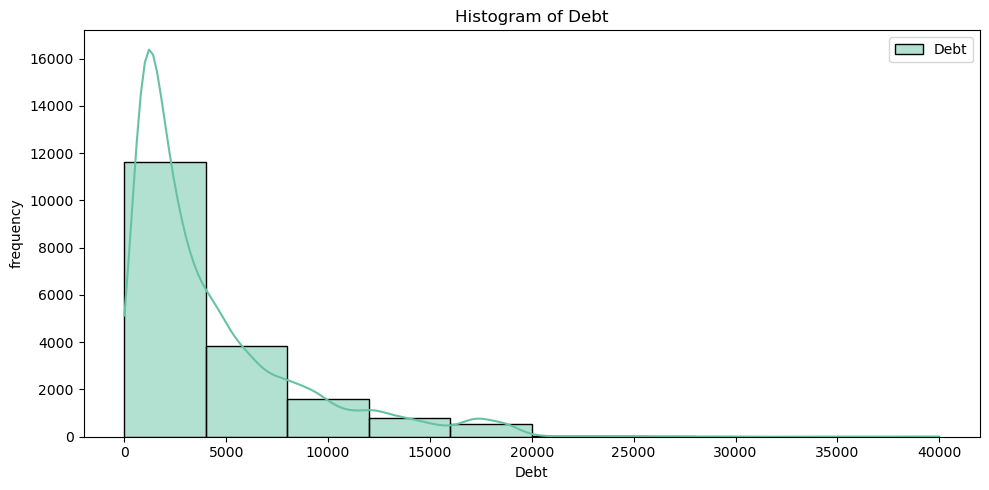

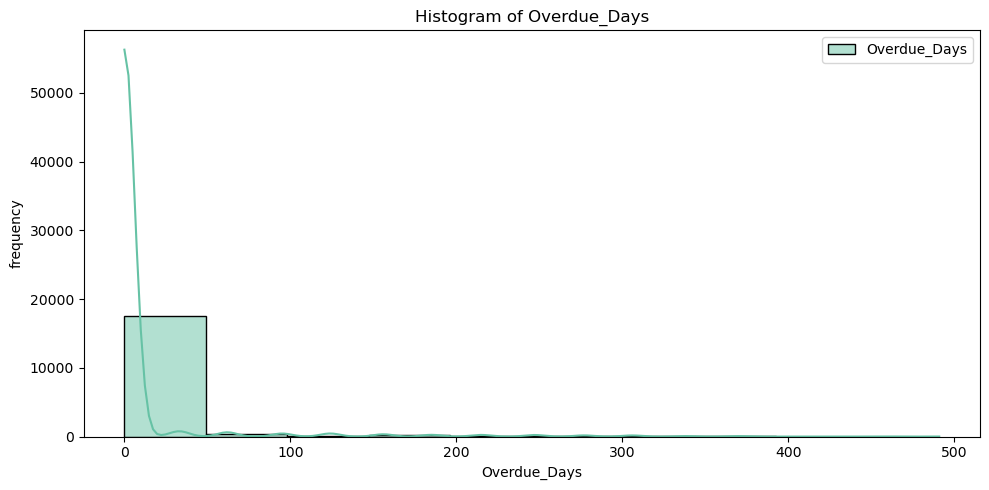

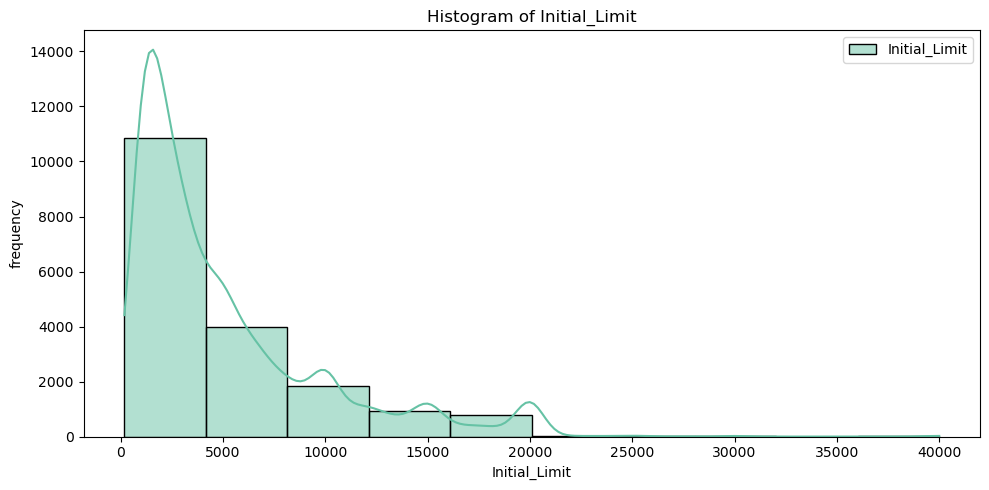

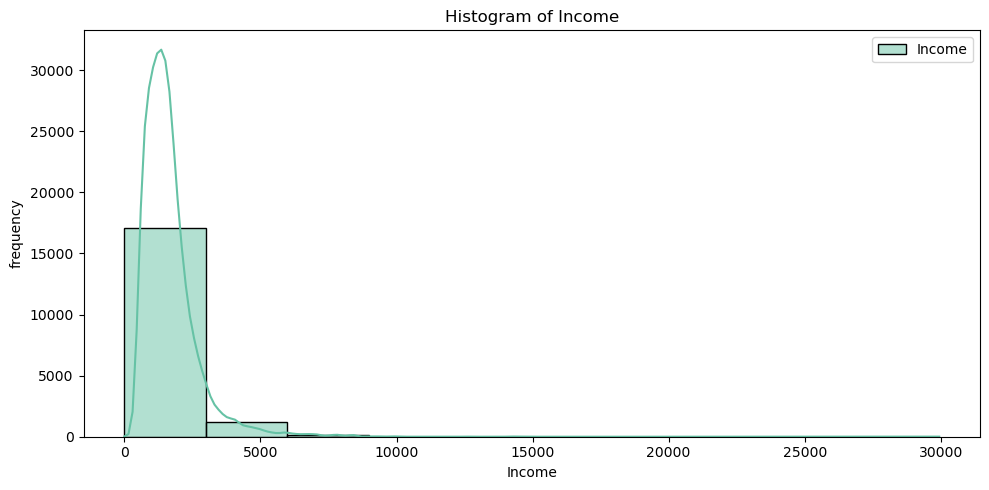

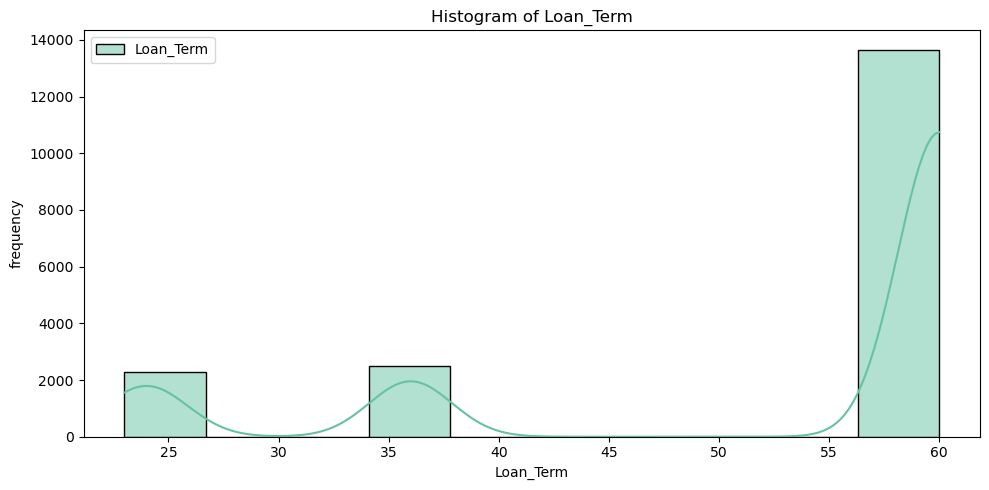

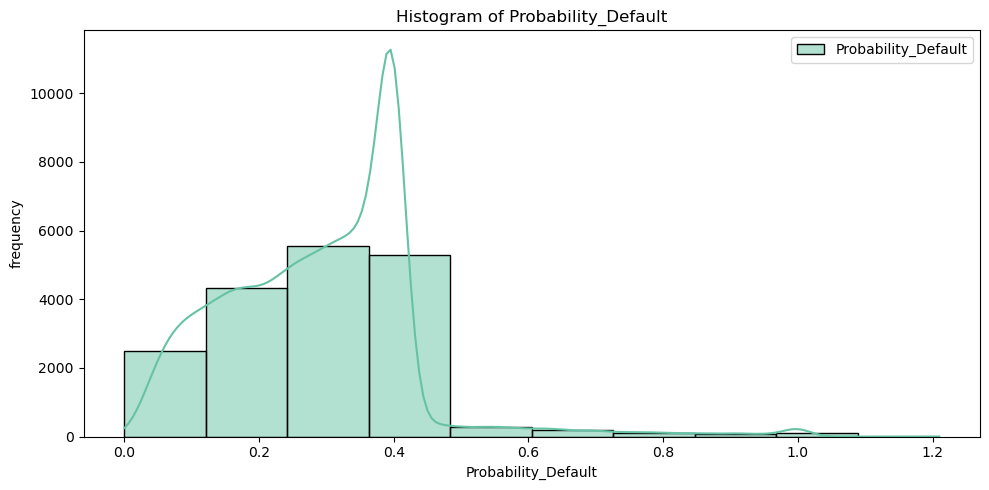

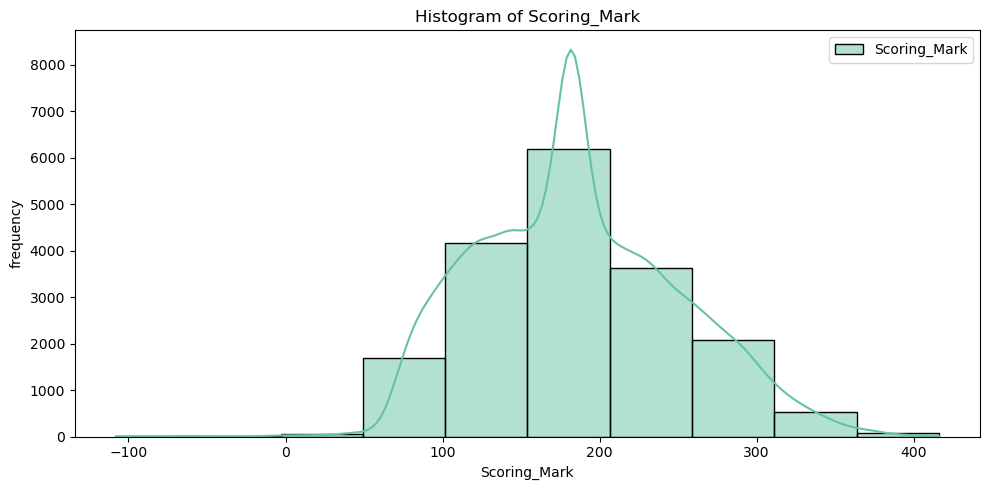

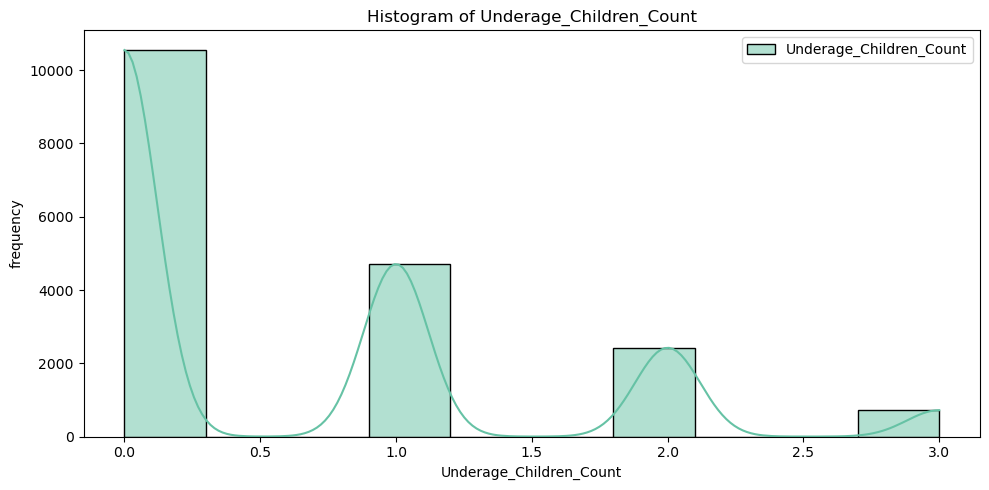

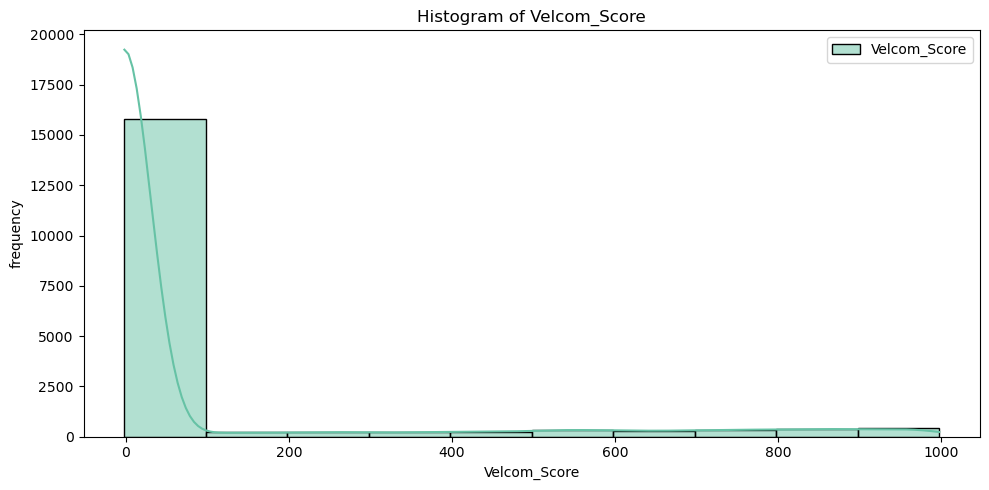

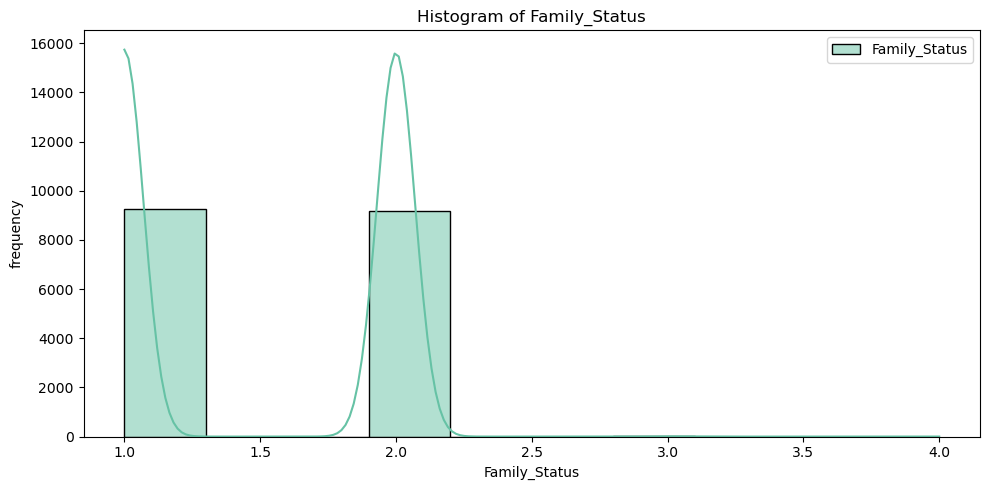

In [43]:
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[[col]], kde=True, palette='Set2', bins=10)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.tight_layout()
    plt.show()

### 2. Countplot Of Cat_Cols

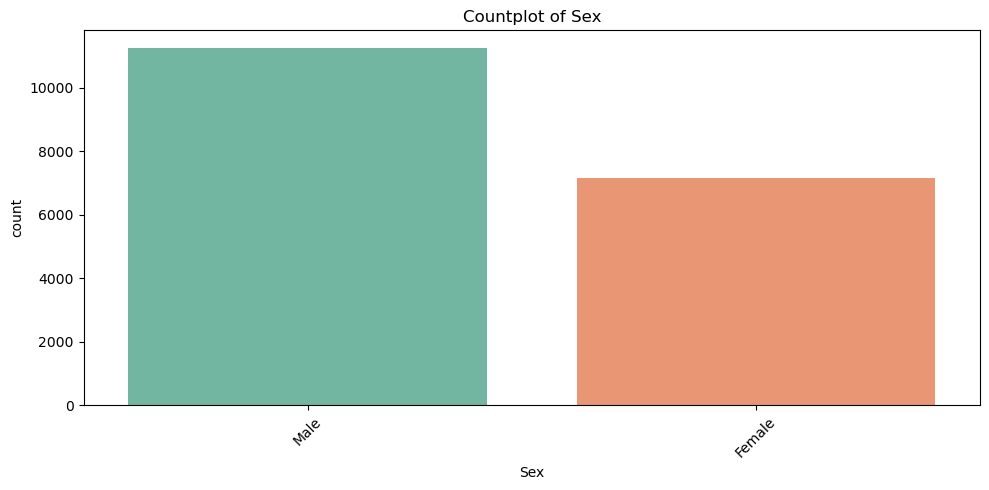

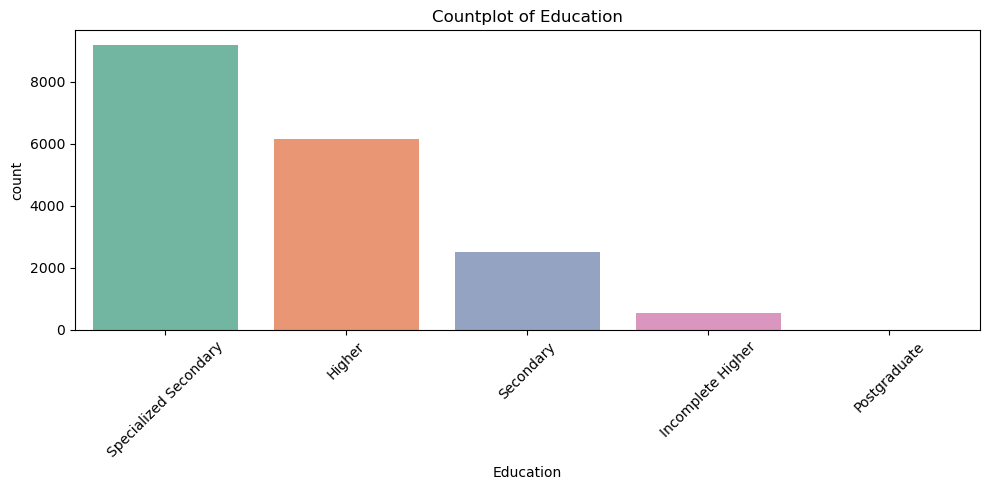

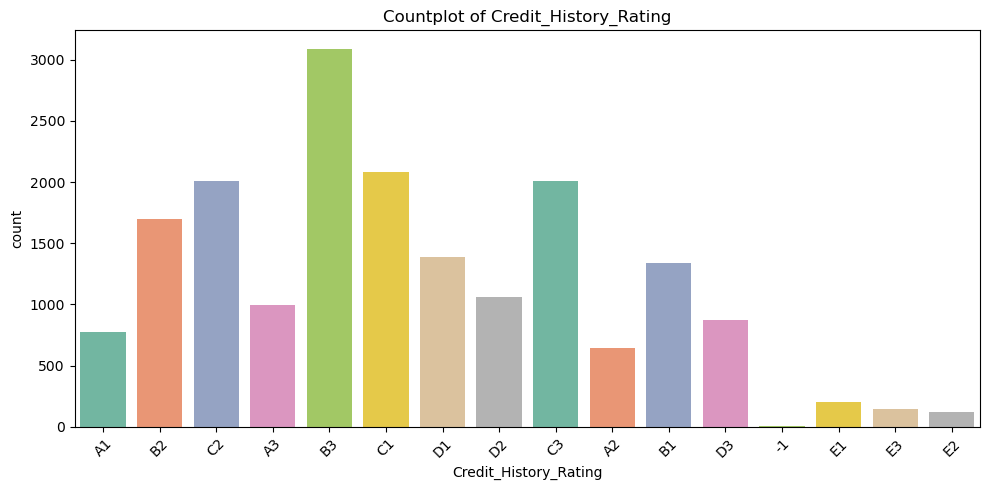

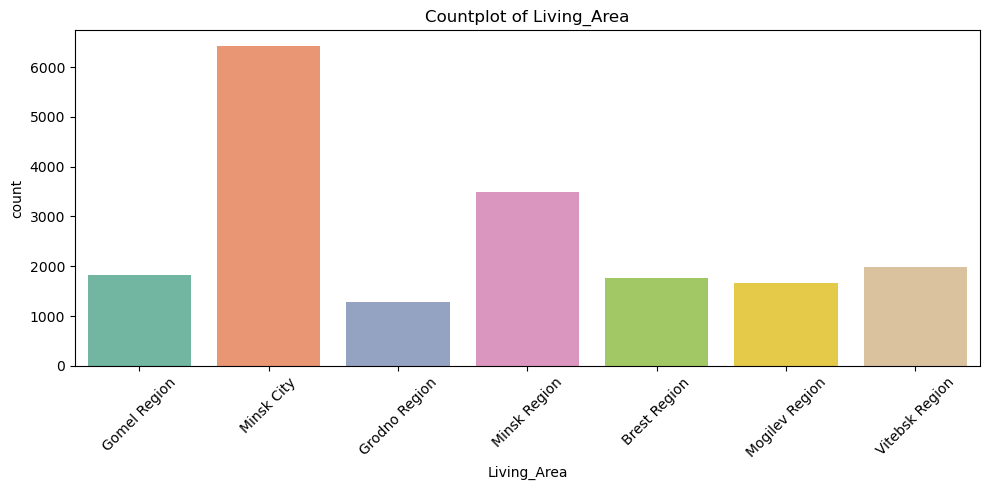

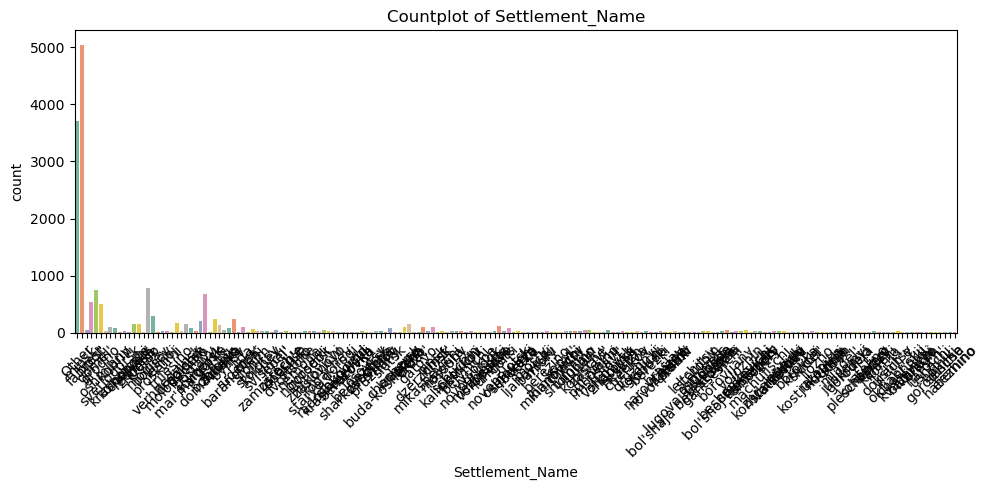

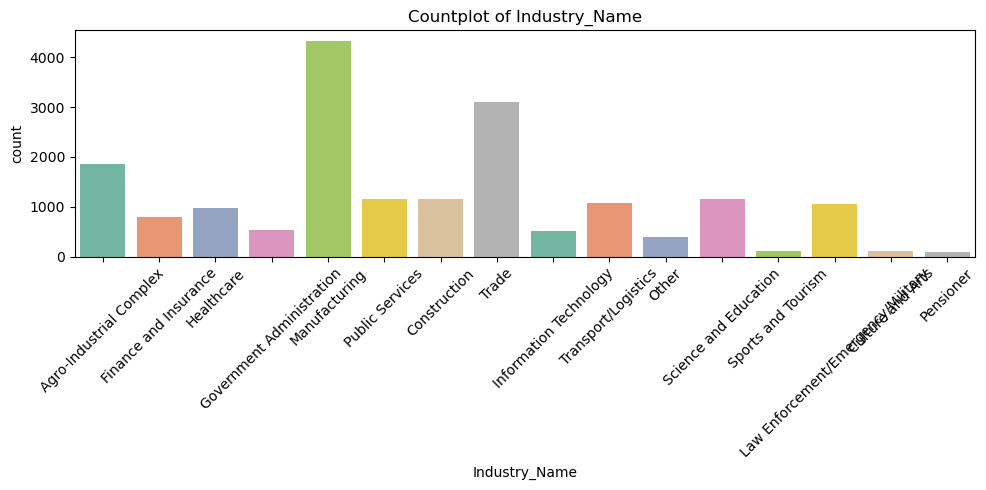

In [44]:
for col in cat_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col, palette='Set2')
    plt.title(f'Countplot of {col}')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 3. Debt vs Income

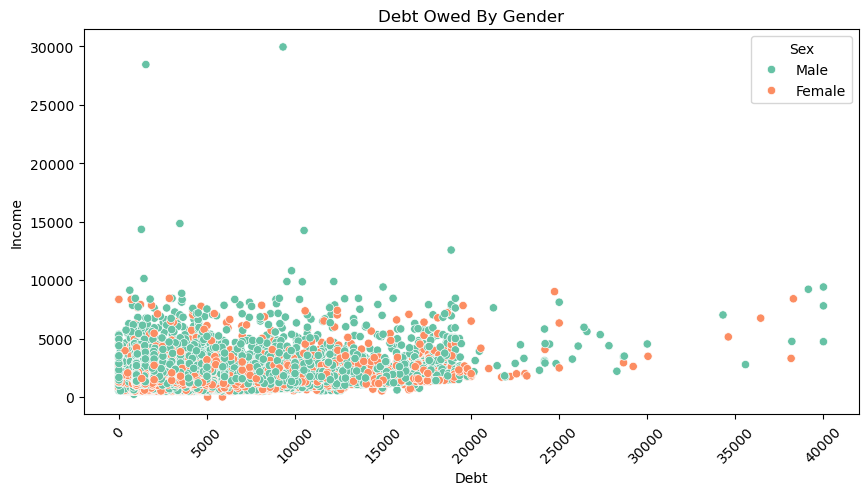

In [48]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Debt'], y=df['Income'], hue=df['Sex'], palette='Set2')
plt.title('Debt Owed By Gender')
plt.xlabel('Debt')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.show()

### 4. Gender vs Education

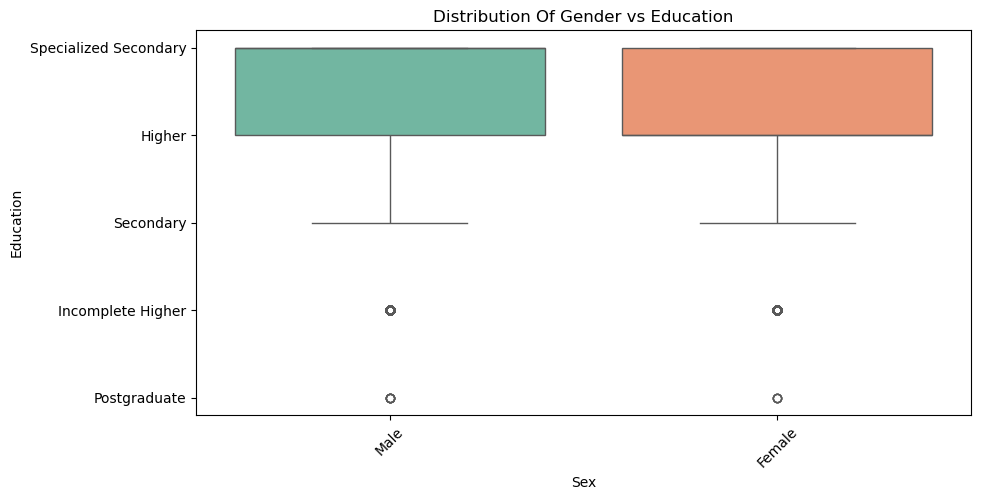

In [54]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Sex'], y=df['Education'], data=df, palette='Set2')
plt.title('Distribution Of Gender vs Education')
plt.xlabel('Sex')
plt.ylabel('Education')
plt.xticks(rotation=45)
plt.show()

### 5. Living Area By Gender

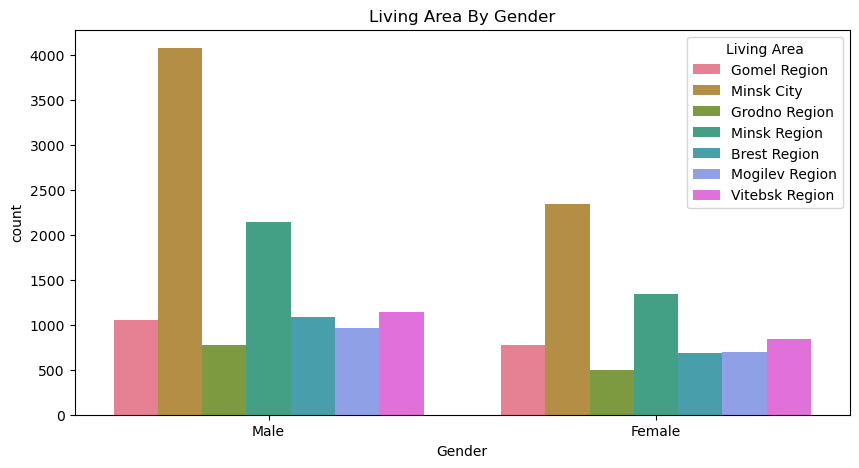

In [55]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Sex'], hue=df['Living_Area'], palette='husl')
plt.title('Living Area By Gender')
plt.xlabel('Gender')
plt.ylabel('count')
plt.legend(title='Living Area')
plt.show()

### 6. Probability Default Against Scoring Mark

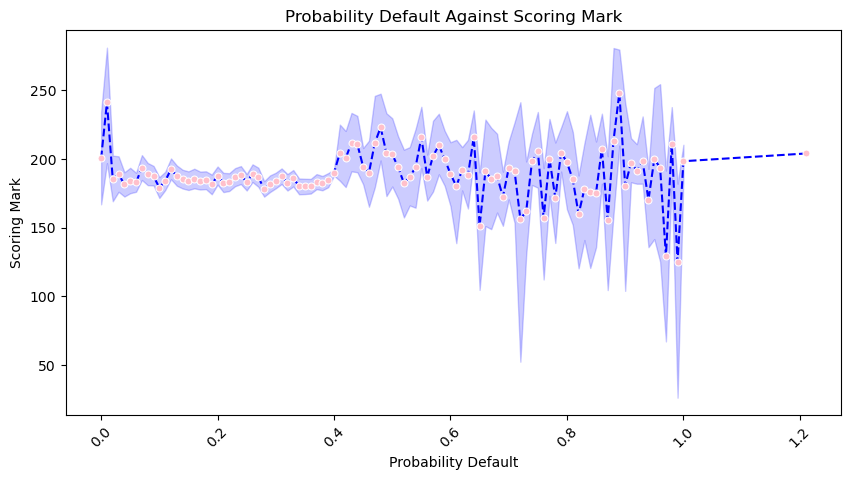

In [56]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df['Probability_Default'], y=df['Scoring_Mark'], marker='o', linestyle='dashed', markerfacecolor='pink', markersize=5, color='blue')
plt.title('Probability Default Against Scoring Mark')
plt.xlabel('Probability Default')
plt.ylabel('Scoring Mark')
plt.xticks(rotation=45)
plt.show()

### 7. Debt vs Initial_Limit

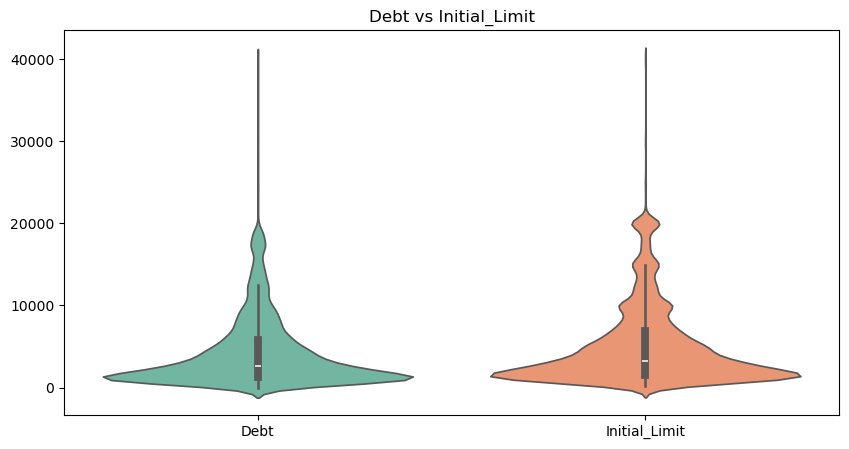

In [60]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df[['Debt', 'Initial_Limit']], palette='Set2')
plt.title('Debt vs Initial_Limit')
plt.show()

In [61]:
df

,Debt,Overdue_Days,Initial_Limit,Birth_Date,Sex,Education,Income,Loan_Term,Credit_History_Rating,Living_Area,Settlement_Name,Industry_Name,Probability_Default,Scoring_Mark,Underage_Children_Count,Velcom_Score,Family_Status
0,6063.50,3,7000.0,1983-07-08,Male,Specialized Secondary,703.07,60,A1,Gomel Region,Other,Agro-Industrial Complex,0.98,233.0,0,-2.0,1
1,3765.04,0,5000.0,1987-12-19,Female,Higher,1693.68,60,B2,Minsk City,minsk,Finance and Insurance,0.17,182.0,1,-2.0,1
2,2067.66,0,2650.0,1966-02-28,Female,Secondary,724.49,60,C2,Grodno Region,Other,Healthcare,0.40,182.0,0,-2.0,2
3,2370.39,0,3000.0,1972-02-18,Female,Specialized Secondary,1045.84,60,A3,Minsk Region,fanipol',Government Administration,0.29,216.0,0,-2.0,2
4,2280.55,0,3000.0,1997-02-23,Female,Higher,1092.65,60,B3,Minsk City,minsk,Healthcare,0.63,182.0,0,-2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,1999-11-08,Male,Higher,3563.75,60,B1,Minsk City,minsk,Information Technology,0.40,344.0,0,-2.0,1
18416,0.00,0,13000.0,1993-06-03,Male,Specialized Secondary,2865.72,36,B3,Minsk Region,Other,Construction,0.19,108.0,2,-2.0,1
18417,0.00,0,3500.0,2002-11-05,Male,Specialized Secondary,3363.05,24,C2,Minsk Region,soligorsk,Construction,0.19,129.0,0,-2.0,2
18418,0.00,0,10000.0,2003-09-15,Male,Secondary,1670.13,60,C1,Minsk City,minsk,Trade,0.28,179.0,0,-2.0,2


### 8. Correlation Map

In [62]:
df['Sex'].unique()

array(['Male', 'Female'], dtype=object)

In [63]:
df['Education'].unique()

array(['Specialized Secondary', 'Higher', 'Secondary',
       'Incomplete Higher', 'Postgraduate'], dtype=object)

In [64]:
df['Credit_History_Rating'].unique()

array(['A1', 'B2', 'C2', 'A3', 'B3', 'C1', 'D1', 'D2', 'C3', 'A2', 'B1',
       'D3', '-1', 'E1', 'E3', 'E2'], dtype=object)

In [65]:
df['Living_Area'].unique()

array(['Gomel Region', 'Minsk City', 'Grodno Region', 'Minsk Region',
       'Brest Region', 'Mogilev Region', 'Vitebsk Region'], dtype=object)

In [66]:
df['Settlement_Name'].unique()

array(['Other', 'minsk', "fanipol'", 'brest', "gomel'", 'grodno',
       'oshmjany', 'svetlogorsk', 'kobrin', "krasnopol'e", 'kolodischi',
       "cherven'", 'rechitsa', 'zhodino', 'kletsk', 'mogilev', 'borisov',
       'proskurni', 'lesnoj', 'verhnedvinsk', 'trilesino', 'molodechno',
       'drogichin', 'polotsk', "mar'ina gorka", 'postavy', 'soligorsk',
       'vitebsk', 'domachevo', 'bobrujsk', 'zhlobin', 'vilejka', 'byhov',
       'baranovichi', 'rudensk', 'lida', "ross'", 'slonim', 'stolbtsy',
       'krichev', "svisloch'", "zamostoch'e", "lepel'", "zarech'e",
       'dobrush', 'dvorische', 'senno', 'nemojta', 'novoselki', 'gorodok',
       'zhitkovichi', 'zaslonovo', 'starye dorogi', 'rogachev',
       'radoshkovichi', "krasnosel'skij", 'slavgorod', 'berezovka',
       'narovlja', 'sharkovschina', 'beloozersk', 'osovtsy', "zabolot'e",
       'pruzhany', 'shklov', 'buda-koshelevo', 'slutsk', 'chechersk',
       'krasnoe', "mozyr'", 'orsha', "ordat'", 'gatovo', 'dzerzhinsk',
      

In [67]:
df['Industry_Name'].unique()

array(['Agro-Industrial Complex', 'Finance and Insurance', 'Healthcare',
       'Government Administration', 'Manufacturing', 'Public Services',
       'Construction', 'Trade', 'Information Technology',
       'Transport/Logistics', 'Other', 'Science and Education',
       'Sports and Tourism', 'Law Enforcement/Emergency/Military',
       'Culture and Arts', 'Pensioner'], dtype=object)

In [68]:
df = df.drop(columns=['Settlement_Name'], errors='ignore')

val = {'Sex': {'Male': 0, 'Female': 1}, 
       'Education': {'Specialized Secondary': 0, 'Higher': 1, 'Secondary': 2, 'Incomplete Higher': 1, 'Postgraduate': 2},
       'Credit_History_Rating': {'A1': 0, 'B2': 1, 'C2': 2, 'A3': 3, 'B3': 4, 'C1': 5, 'D1': 6, 'D2': 7, 'C3': 8, 'A2': 9, 'B1': 10, 'D3': 11, '-1': 12, 'E1': 13, 'E3': 14, 'E2': 15},
       'Living_Area': {'Gomel Region': 0, 'Minsk City': 1, 'Grodno Region': 2, 'Minsk Region': 3, 'Brest Region': 4, 'Mogilev Region': 5, 'Vitebsk Region': 6},
       'Industry_Name': {'Agro-Industrial Complex': 0, 'Finance and Insurance': 1, 'Healthcare': 2, 'Government Administration': 3, 
                         'Manufacturing': 4, 'Public Services': 5, 'Construction': 6, 'Trade': 7, 'Information Technology': 8, 'Transport/Logistics': 9, 'Other': 10, 
                         'Science and Education': 11, 'Sports and Tourism': 12, 'Law Enforcement/Emergency/Military': 13, 'Culture and Arts': 14, 'Pensioner': 15}}
df.replace(val, inplace=True)
df

,Debt,Overdue_Days,Initial_Limit,Birth_Date,Sex,Education,Income,Loan_Term,Credit_History_Rating,Living_Area,Industry_Name,Probability_Default,Scoring_Mark,Underage_Children_Count,Velcom_Score,Family_Status
0,6063.50,3,7000.0,1983-07-08,0,0,703.07,60,0,0,0,0.98,233.0,0,-2.0,1
1,3765.04,0,5000.0,1987-12-19,1,1,1693.68,60,1,1,1,0.17,182.0,1,-2.0,1
2,2067.66,0,2650.0,1966-02-28,1,2,724.49,60,2,2,2,0.40,182.0,0,-2.0,2
3,2370.39,0,3000.0,1972-02-18,1,0,1045.84,60,3,3,3,0.29,216.0,0,-2.0,2
4,2280.55,0,3000.0,1997-02-23,1,1,1092.65,60,4,1,2,0.63,182.0,0,-2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,1999-11-08,0,1,3563.75,60,10,1,8,0.40,344.0,0,-2.0,1
18416,0.00,0,13000.0,1993-06-03,0,0,2865.72,36,4,3,6,0.19,108.0,2,-2.0,1
18417,0.00,0,3500.0,2002-11-05,0,0,3363.05,24,2,3,6,0.19,129.0,0,-2.0,2
18418,0.00,0,10000.0,2003-09-15,0,2,1670.13,60,5,1,7,0.28,179.0,0,-2.0,2


In [69]:
df = df.drop(columns=['Birth_Date'], errors='ignore')

In [70]:
df

,Debt,Overdue_Days,Initial_Limit,Sex,Education,Income,Loan_Term,Credit_History_Rating,Living_Area,Industry_Name,Probability_Default,Scoring_Mark,Underage_Children_Count,Velcom_Score,Family_Status
0,6063.50,3,7000.0,0,0,703.07,60,0,0,0,0.98,233.0,0,-2.0,1
1,3765.04,0,5000.0,1,1,1693.68,60,1,1,1,0.17,182.0,1,-2.0,1
2,2067.66,0,2650.0,1,2,724.49,60,2,2,2,0.40,182.0,0,-2.0,2
3,2370.39,0,3000.0,1,0,1045.84,60,3,3,3,0.29,216.0,0,-2.0,2
4,2280.55,0,3000.0,1,1,1092.65,60,4,1,2,0.63,182.0,0,-2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18415,0.00,0,10850.0,0,1,3563.75,60,10,1,8,0.40,344.0,0,-2.0,1
18416,0.00,0,13000.0,0,0,2865.72,36,4,3,6,0.19,108.0,2,-2.0,1
18417,0.00,0,3500.0,0,0,3363.05,24,2,3,6,0.19,129.0,0,-2.0,2
18418,0.00,0,10000.0,0,2,1670.13,60,5,1,7,0.28,179.0,0,-2.0,2


In [71]:
correlation = df.corr()

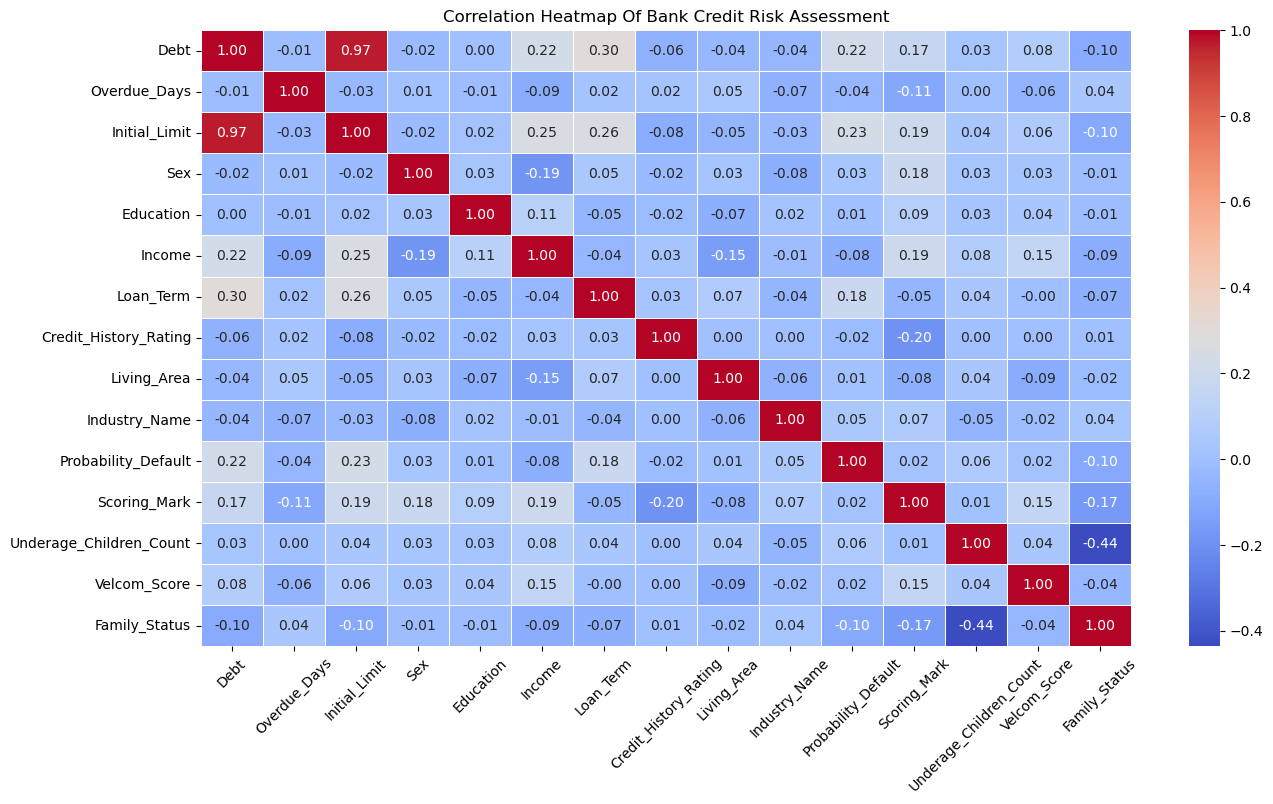

In [74]:
plt.figure(figsize=(15, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5)
plt.title('Correlation Heatmap Of Bank Credit Risk Assessment')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Predictive Modeling

### 1. Train Test Split

In [81]:
features = ['Debt', 'Overdue_Days', 'Initial_Limit', 'Income', 'Loan_Term', 'Probability_Default', 'Scoring_Mark', 'Underage_Children_Count', 'Velcom_Score', 'Family_Status']
target = 'Sex'

X = df[features]
y = df[target]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(14736, 10) (3684, 10)


### 2. Models

In [85]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0),
}

#### Train and Evaluate Models

In [87]:
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'MAE': mae}
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Linear Regression - RMSE: 0.4643, MAE: 0.4351
Random Forest - RMSE: 0.4570, MAE: 0.3975
CatBoost - RMSE: 0.4489, MAE: 0.3947


### Visualize Model Performance

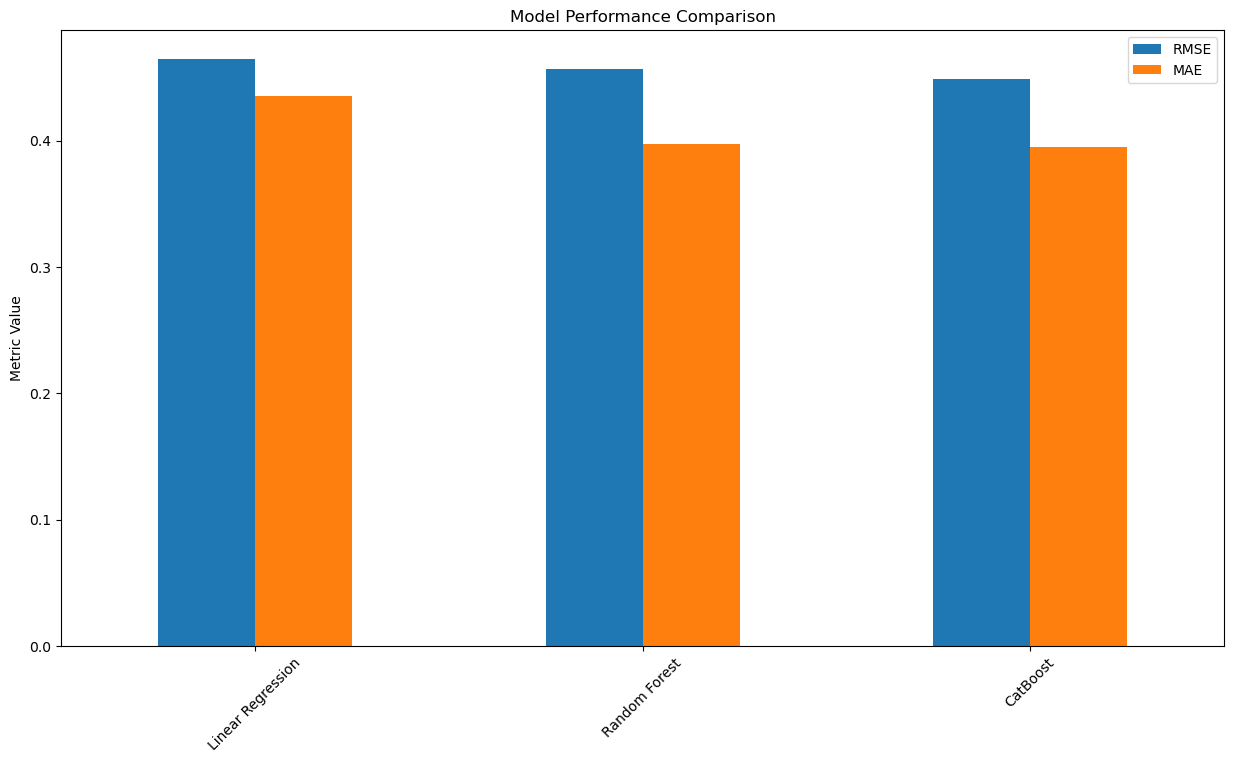

In [88]:
plt.figure(figsize=(15, 8))
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.show()